# 01_Mutation_Deconvolution

Goal: map mutations to individual cells.

1. Mutations are called using all reads combined from all cells
1. Count reads per cell barcode to get a per cell mutation count
1. "phasing"?

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
import os
import tqdm
import pysam
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
results_dir = '/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/01'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [5]:
colon_dna_fn = '/broad/thechenlab/pipeline_slidetag/data/240609_SL-EXC_0308_A22KHFYLT3/count'
colon_rna_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger'
colon_spatial_fn = '/broad/thechenlab/Andy/slide_tag_dna/colon_droplet/data/Mehdi_smaht_153_celltypes_locations.csv'
# bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/cellranger/xBO153_GEX_240625/outs/possorted_genome_bam.bam' # RNA
bam_fn = '/broad/thechenlab/Benno/experiments/xBO153/bams/xBO153_G.markdup.bam' 
maf_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/data/xSDS_variants.txt'

# mapping barcodes
atac_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/atac/barcodes/737K-arc-v1.txt.gz'
rna_bcs_fn = '/broad/thechenlab/Andy/software/cellranger-arc-2.0.2/lib/python/cellranger/barcodes/737K-arc-v1.txt.gz'

# Conversion

In [6]:
atac_bcs_df = pd.read_csv(atac_bcs_fn, compression='gzip', header=None).rename(columns={0: 'ATAC'})
rna_bcs_df = pd.read_csv(rna_bcs_fn, compression='gzip', header=None).rename(columns={0: 'RNA'})

In [7]:
convert_cb_df = pd.concat([atac_bcs_df, rna_bcs_df], axis=1)

old_bases = "ACGT"
replace_bases = "TGCA"
tab = str.maketrans(old_bases,replace_bases)

convert_cb_df['CB'] = convert_cb_df['ATAC'].apply(lambda x: x[::-1].translate(tab))
convert_cb_df = convert_cb_df.set_index('CB') # lookup

In [8]:
convert_cb_df

,ATAC,RNA
CB,,
GTAACACACCCGCTGT,ACAGCGGGTGTGTTAC,AAACAGCCAAACAACA
AAGAACAACCCGCTGT,ACAGCGGGTTGTTCTT,AAACAGCCAAACATAG
GCCTGTTACCCGCTGT,ACAGCGGGTAACAGGC,AAACAGCCAAACCCTA
TTCGCGCACCCGCTGT,ACAGCGGGTGCGCGAA,AAACAGCCAAACCTAT
ATGGAGGACCCGCTGT,ACAGCGGGTCCTCCAT,AAACAGCCAAACCTTG
...,...,...
TGCTATGTGAAGTACG,CGTACTTCACATAGCA,TTTGTTGGTTTGGGTA
TTGCATGTGAAGTACG,CGTACTTCACATGCAA,TTTGTTGGTTTGGTTC
TACAACCTGAAGTACG,CGTACTTCAGGTTGTA,TTTGTTGGTTTGTCTA


In [301]:
convert_cb_fn = '/broad/thechenlab/ClaudiaC/droplet_DNA/refs/convert_cb.tsv'
convert_cb_df.to_csv(convert_cb_fn, sep='\t')

# Maf

In [9]:
maf_df = pd.read_csv(maf_fn, sep='\t')

In [10]:
maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF
0,chr1,16856,A,G,5,44,0.113636
1,chr1,108540,A,C,7,44,0.159091
2,chr1,127491,T,G,16,70,0.228571
3,chr1,268043,C,T,11,78,0.141026
4,chr1,275337,T,C,6,55,0.109091
...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474
68877,chrY,56881603,G,A,8,93,0.086022
68878,chrY,56881615,T,C,8,90,0.088889
68879,chrY,56881889,G,C,10,95,0.105263


1. Iterate through each mutation
1. Get all the reads for that mutation
1. count reads per cell barcode

In [11]:
cb_counts_fn = f'{results_dir}/cb_counts.tsv'
cb_counts_fn

'/broad/thechenlab/ClaudiaC/droplet_DNA/sandbox/results/01/cb_counts.tsv'

In [12]:

with pysam.AlignmentFile(bam_fn, "rb") as bam:
    cb_counts = {}
    for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
        chrom = r['Chr']
        pos = r['Pos']
        ref_base = r['Ref']
        alt_base = r['Alt']

        num_reads = 0
        num_alt_reads = 0
        alt_relative_positions = []
        for read in bam.fetch(chrom, pos - 1, pos):  # Fetch reads overlapping mutation site
            if read.is_unmapped or read.is_secondary or read.is_supplementary or read.is_duplicate:
                continue  # Skip unmapped/secondary/supplementary alignments

            aligned_pairs = read.get_aligned_pairs(matches_only=True)  # List of (read_pos, ref_pos)
            read_length = read.query_length
            tags = {tag_name: tag_value for tag_name, tag_value in read.get_tags()}
            CB = tags['CB']
            
            try:
                cb_counts[(i, CB)]
            except KeyError:
                cb_counts[(i, CB)] = {'alt': 0, 'ref': 0, 'other': 0}

            for read_pos, ref_pos in aligned_pairs:
                if ref_pos == pos - 1:  # 0-based in pysam
                    read_base = read.query_sequence[read_pos]

                    if read_base == alt_base:  # Mutation is present in read
                        cb_counts[(i, CB)]['alt'] += 1
                    elif read_base == ref_base:
                        cb_counts[(i, CB)]['ref'] += 1
                    else:
                        cb_counts[(i, CB)]['other'] += 1
                    
                    break  # No need to check further in this read
pd.DataFrame.from_dict(cb_counts).T.to_csv(cb_counts_fn, sep='\t', compression='gzip')

  1%|█                                                                                                                     | 651/68881 [00:02<04:49, 235.62it/s]


KeyboardInterrupt: 

In [ ]:
del cb_counts

In [71]:
cb_counts_df = pd.read_csv(cb_counts_fn, sep='\t', compression='gzip', index_col=[0, 1])
cb_counts_df.index.set_names(['maf_idx', 'CB'], inplace=True)
cb_counts_df['genotype'] = cb_counts_df['alt'].astype(str) + '/' + cb_counts_df['ref'].astype(str)
cb_counts_df['has_alt'] = cb_counts_df['alt'] > 0 # naive calling

In [275]:
maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
0,chr1,16856,A,G,5,44,0.113636,0.0,1.0,0.000000,0.000000,1.0
1,chr1,108540,A,C,7,44,0.159091,0.0,2.0,4257.471057,4257.471057,2.0
2,chr1,127491,T,G,16,70,0.228571,0.0,3.0,1995.358693,1477.602969,3.0
3,chr1,268043,C,T,11,78,0.141026,0.0,2.0,2379.343187,2379.343187,2.0
4,chr1,275337,T,C,6,55,0.109091,0.0,3.0,682.600559,531.186754,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474,1.0,6.0,592.596702,473.749510,8.0
68877,chrY,56881603,G,A,8,93,0.086022,2.0,8.0,426.856579,365.575918,12.0
68878,chrY,56881615,T,C,8,90,0.088889,4.0,7.0,359.732644,192.454720,15.0
68879,chrY,56881889,G,C,10,95,0.105263,1.0,1.0,186.051942,68.134522,3.0


In [276]:
cb_counts_df.loc[0]

,alt,ref,other,genotype,has_alt,DBSCAN_n_clusters,DBSCAN_n_noise
CB,,,,,,,
AGCCCTTACCAGGTTG,0,2,0,0/2,False,NaN,NaN
ATATGCGACAGCTAAC,0,1,0,0/1,False,NaN,NaN
CTCAAGGACAGTAAGA,2,0,0,2/0,True,NaN,NaN
CTTGACCGAGGAGGGT,0,2,0,0/2,False,NaN,NaN
CGGATTAGAGCTTAGG,2,0,0,2/0,True,NaN,NaN
...,...,...,...,...,...,...,...
ATCCGGGACATCCAGA,0,2,0,0/2,False,NaN,NaN
GGAGCTTGAGCTAAGC,0,2,0,0/2,False,NaN,NaN
CAGTGTGACCGGGTTA,0,2,0,0/2,False,NaN,NaN


For each mutation, there is an average count, and then counts are different per measured cell. Want to genotype the individual cells, or detect "consistency" across the cells making up the measured cell population. Calculate variance?

Given average, what is the likelihood a given cell generated that average

In [98]:
cb_maf_df = cb_counts_df.groupby('maf_idx')[['alt', 'ref']].sum() # sum over read counts for only the CBs with reads. Should be the same as before?
cb_maf_df['num_CBs'] = cb_counts_df.groupby('maf_idx').size()
cb_maf_df['num_CBs_with_alt'] = cb_counts_df.query('has_alt').groupby(['maf_idx']).size()
cb_maf_df['total'] = cb_maf_df['alt'] + cb_maf_df['ref']
cb_maf_df['CB_VAF'] = cb_maf_df['alt'] / (cb_maf_df['total'])
cb_maf_df['bulk_VAF'] = maf_df.loc[cb_maf_df.index, 'VAF'].copy()
# cb_maf_df['log(total)'] = np.log(cb_maf_df['total'])
cb_maf_df.head()

,alt,ref,num_CBs,num_CBs_with_alt,total,CB_VAF,bulk_VAF
maf_idx,,,,,,,
0,15,100,65,8.0,115,0.130435,0.113636
1,7,48,34,5.0,55,0.127273,0.159091
2,29,103,75,16.0,132,0.219697,0.228571
3,12,102,65,7.0,114,0.105263,0.141026
4,9,74,51,6.0,83,0.108434,0.109091


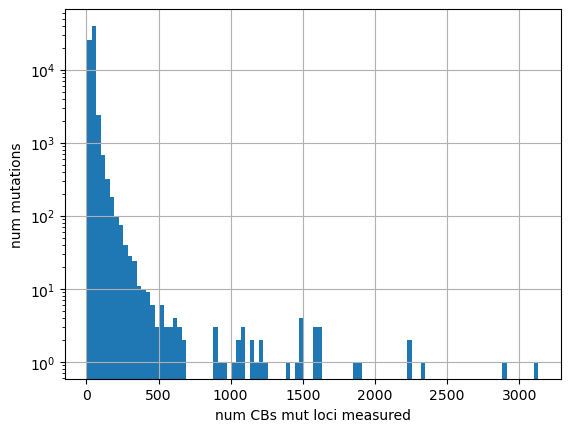

In [101]:
cb_maf_df['num_CBs'].hist(bins=100)
plt.yscale('log')
plt.ylabel('num mutations')
plt.xlabel('num CBs mut loci measured')
plt.show()

3000 all captured same region?

In [278]:
maf_df.loc[cb_maf_df.sort_values(by='num_CBs').index]

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
maf_idx,,,,,,,,,,,,
2644,chr1,122112102,A,T,5,51,0.098039,0.0,2.0,4993.612311,4993.612311,2.0
18730,chr14,100514090,C,A,5,41,0.121951,1.0,2.0,NaN,NaN,NaN
50426,chr5,176760348,GC,AT,3,40,0.075000,1.0,1.0,NaN,NaN,NaN
28091,chr19,53898873,GGAGGGGCTCCTCGGGGGCGTGGCCAGGTGGAGGGACTCATCGGGG...,G,3,30,0.100000,0.0,3.0,767.495384,233.118906,3.0
23862,chr17,23194838,G,C,8,46,0.173913,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
43414,chr4,49154957,A,ATT,8,84,0.095238,1.0,0.0,NaN,NaN,NaN
68870,chrY,11525305,G,C,5,68,0.073529,1.0,3.0,NaN,NaN,NaN
2732,chr1,143191565,T,C,7,75,0.093333,6.0,8.0,176.908231,158.395347,32.0


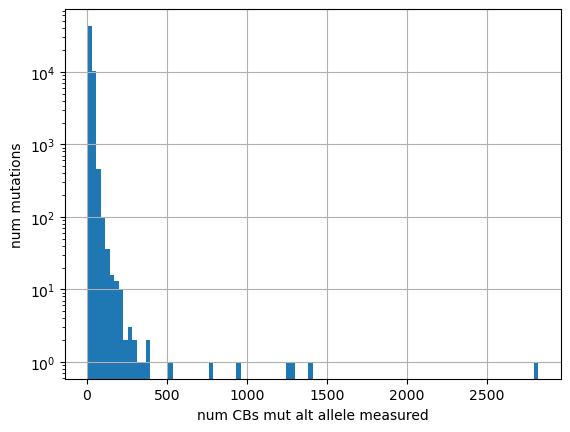

In [103]:
cb_maf_df['num_CBs_with_alt'].hist(bins=100)
plt.yscale('log')
plt.ylabel('num mutations')
plt.xlabel('num CBs mut alt allele measured')
plt.show()

In [279]:
cb_maf_df.query('CB_VAF == 1.0')

,alt,ref,num_CBs,num_CBs_with_alt,total,CB_VAF,bulk_VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
maf_idx,,,,,,,,,,,,
6,61,0,38,38.0,61,1.0,0.152174,2.0,8.0,447.185610,274.633337,12.0
17,108,0,71,70.0,108,1.0,0.128571,9.0,6.0,180.728369,151.910257,32.0
18,39,0,22,22.0,39,1.0,0.085714,0.0,9.0,404.917958,303.115278,9.0
23,101,0,56,56.0,101,1.0,0.040541,3.0,14.0,323.996112,302.730501,20.0
26,48,0,28,28.0,48,1.0,0.062500,1.0,9.0,337.580377,218.894642,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68848,45,0,27,27.0,45,1.0,0.048387,0.0,7.0,475.244791,313.613876,7.0
68849,27,0,18,18.0,27,1.0,0.069767,1.0,4.0,412.573382,219.333581,6.0
68850,56,0,33,33.0,56,1.0,0.100000,2.0,10.0,373.873503,317.323258,14.0


In [280]:
maf_df.loc[cb_maf_df.query('CB_VAF == 1.0').index]

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
maf_idx,,,,,,,,,,,,
6,chr1,278240,CAA,C,7,46,0.152174,2.0,8.0,447.185610,274.633337,12.0
17,chr1,1030889,ATGTGTGTGTGTGCAGTGCATGGTGCTGTGAGATCAGCG,A,9,70,0.128571,9.0,6.0,180.728369,151.910257,32.0
18,chr1,1202929,TGGGGG,T,3,35,0.085714,0.0,9.0,404.917958,303.115278,9.0
23,chr1,1696875,AGTGT,A,3,74,0.040541,3.0,14.0,323.996112,302.730501,20.0
26,chr1,1804758,AAGTCC,A,3,48,0.062500,1.0,9.0,337.580377,218.894642,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68848,chrX,155789224,GTCATA,G,3,62,0.048387,0.0,7.0,475.244791,313.613876,7.0
68849,chrX,155796830,TTTTAA,T,3,43,0.069767,1.0,4.0,412.573382,219.333581,6.0
68850,chrX,155813914,GACTAAA,G,3,30,0.100000,2.0,10.0,373.873503,317.323258,14.0


In [285]:
maf_df['type'] = (maf_df['Ref'].apply(len) > 1) | (maf_df['Alt'].apply(len) > 1)

In [286]:
maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor,type
0,chr1,16856,A,G,5,44,0.113636,0.0,1.0,0.000000,0.000000,1.0,False
1,chr1,108540,A,C,7,44,0.159091,0.0,2.0,4257.471057,4257.471057,2.0,False
2,chr1,127491,T,G,16,70,0.228571,0.0,3.0,1995.358693,1477.602969,3.0,False
3,chr1,268043,C,T,11,78,0.141026,0.0,2.0,2379.343187,2379.343187,2.0,False
4,chr1,275337,T,C,6,55,0.109091,0.0,3.0,682.600559,531.186754,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474,1.0,6.0,592.596702,473.749510,8.0,False
68877,chrY,56881603,G,A,8,93,0.086022,2.0,8.0,426.856579,365.575918,12.0,False
68878,chrY,56881615,T,C,8,90,0.088889,4.0,7.0,359.732644,192.454720,15.0,False
68879,chrY,56881889,G,C,10,95,0.105263,1.0,1.0,186.051942,68.134522,3.0,False


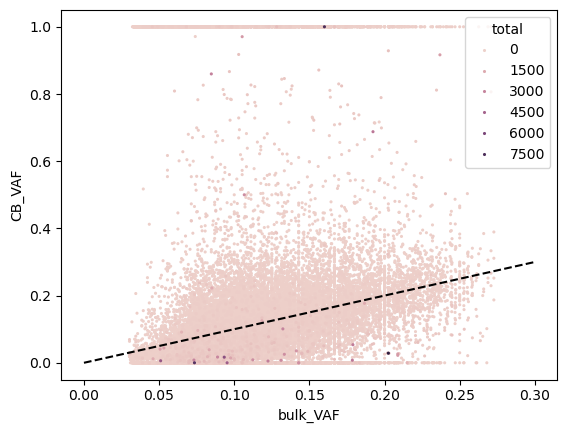

In [69]:
sns.scatterplot(cb_maf_df.sort_values(by='total'), x='bulk_VAF', y='CB_VAF', hue='total', s=5, linewidth=0)
plt.plot([0, 0.3], [0, 0.3], c='k', linestyle='--')

In [287]:
cb_counts_df.groupby(['alt', 'ref']).size().apply(np.log).to_frame()

0
alt ref           
0   0    11.519832
    1    13.507420
    2    14.274978
    3     9.818256
    4     9.548811
...            ...
14  0     0.693147
15  0     0.693147
17  0     0.000000
18  0     0.000000
19  0     0.000000

[95 rows x 1 columns]

<Axes: xlabel='alt', ylabel='ref'>

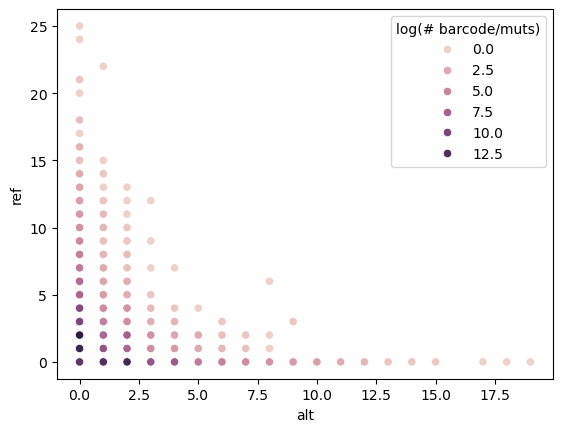

In [26]:
sns.scatterplot(cb_counts_df.groupby(['alt', 'ref']).size().apply(np.log).to_frame().rename(columns={0: 'log(# barcode/muts)'}).reset_index(), x='alt', y='ref', hue='log(# barcode/muts)')

In [27]:
cb_counts_df.genotype.value_counts()

genotype
0/2     1583230
0/1      734849
2/0      462935
1/0      213347
0/0      100693
         ...   
2/12          1
1/15          1
17/0          1
18/0          1
19/0          1
Name: count, Length: 95, dtype: int64

In [28]:
colon_spatial_df = pd.read_csv(colon_spatial_fn, sep=',', index_col=0)

<Axes: xlabel='x', ylabel='y'>

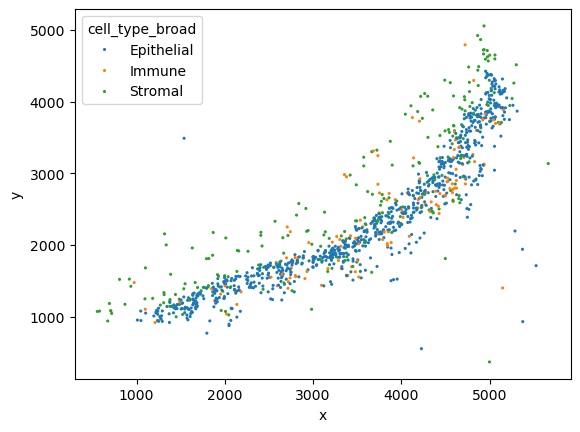

In [29]:
sns.scatterplot(colon_spatial_df, x='x', y='y', hue='cell_type_broad', linewidth=0, s=5)

<Axes: >

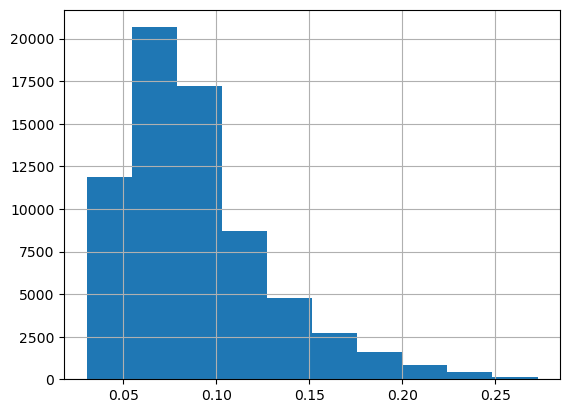

In [30]:
maf_df['VAF'].hist()

In [292]:
maf_df.shape

(68881, 13)

In [289]:
maf_df.sort_values(by='VAF').tail()

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor,type
16986,chr14,19493279,T,C,26,96,0.270833,1.0,4.0,518.960419,592.788561,6.0,False
63041,chr9,42486398,G,C,27,99,0.272727,0.0,7.0,776.943874,697.521834,7.0,False
25739,chr18,15608459,T,G,27,99,0.272727,0.0,11.0,368.134908,322.848974,11.0,False
6690,chr10,50176779,A,G,27,99,0.272727,0.0,5.0,291.898967,301.661548,5.0,False
6370,chr10,42173848,G,A,27,99,0.272727,1.0,5.0,464.085745,292.672292,7.0,False


In [291]:
cb_maf_df.loc[maf_df.sort_values(by='VAF').tail().index]

,alt,ref,num_CBs,num_CBs_with_alt,total,CB_VAF,bulk_VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
16986,25,84,62,14.0,109,0.229358,0.270833,1.0,4.0,518.960419,592.788561,6.0
63041,23,100,73,17.0,123,0.186992,0.272727,0.0,7.0,776.943874,697.521834,7.0
25739,42,93,84,31.0,135,0.311111,0.272727,0.0,11.0,368.134908,322.848974,11.0
6690,31,92,66,17.0,123,0.252033,0.272727,0.0,5.0,291.898967,301.661548,5.0
6370,51,80,70,25.0,131,0.389313,0.272727,1.0,5.0,464.085745,292.672292,7.0


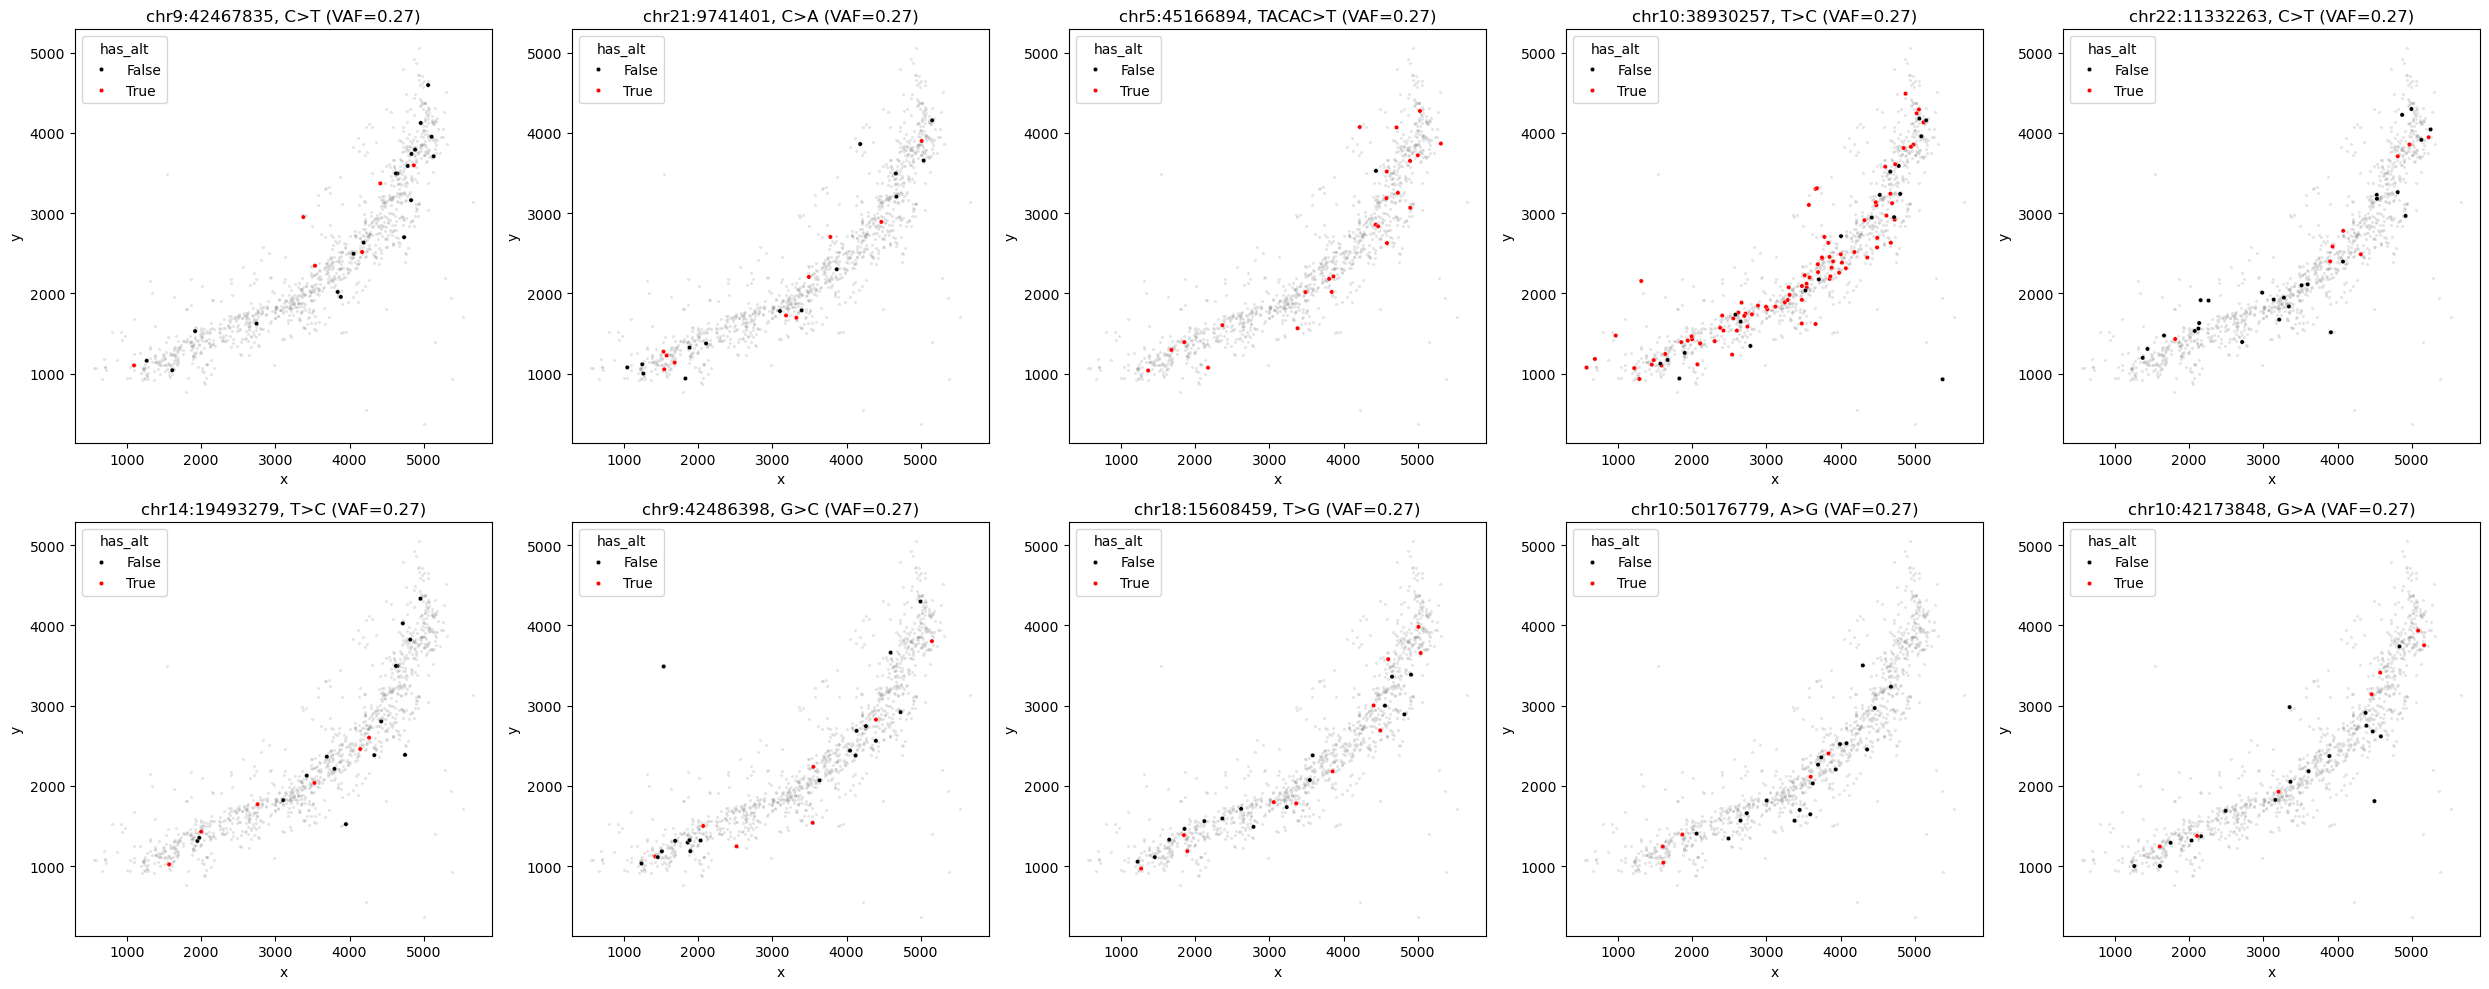

In [76]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
flat_axes = axes.flatten()

j = 0
for i, r in maf_df.sort_values(by='VAF').tail(10).iterrows():
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner')
    
    sns.scatterplot(colon_spatial_df, x='x', y='y', color='gray', alpha=0.2, linewidth=0, s=5, ax=flat_axes[j])
    sns.scatterplot(i_cb_df, x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
    flat_axes[j].set_title(f'{r["Chr"]}:{r["Pos"]}, {r["Ref"]}>{r["Alt"]} (VAF={r["VAF"]:.2f})')
    j += 1
    
plt.tight_layout()
plt.show()

TODO: Filter coverage of mutation region in at least X number of spatially barcoded cells

In [33]:
maf_df.sort_values(by='NR')

,Chr,Pos,Ref,Alt,NV,NR,VAF
31414,chr2,130425745,CA,C,2,27,0.074074
17930,chr14,62782711,T,C,2,27,0.074074
37279,chr22,26127184,GGGGGC,G,2,27,0.074074
18848,chr14,105654338,T,TCATC,2,27,0.074074
31415,chr2,130425748,C,G,2,27,0.074074
...,...,...,...,...,...,...,...
52540,chr6,81012498,TG,T,9,99,0.090909
372,chr1,16850134,CACATACACATATACATAT,C,16,99,0.161616
23591,chr17,20649404,C,T,20,99,0.202020
52806,chr6,93685743,CCACA,C,8,99,0.080808


TODO: subset again for cells with a spatial

In [293]:
maf_df.query("Chr == ''")

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor,type
0,chr1,16856,A,G,5,44,0.113636,0.0,1.0,0.000000,0.000000,1.0,False
1,chr1,108540,A,C,7,44,0.159091,0.0,2.0,4257.471057,4257.471057,2.0,False
2,chr1,127491,T,G,16,70,0.228571,0.0,3.0,1995.358693,1477.602969,3.0,False
3,chr1,268043,C,T,11,78,0.141026,0.0,2.0,2379.343187,2379.343187,2.0,False
4,chr1,275337,T,C,6,55,0.109091,0.0,3.0,682.600559,531.186754,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474,1.0,6.0,592.596702,473.749510,8.0,False
68877,chrY,56881603,G,A,8,93,0.086022,2.0,8.0,426.856579,365.575918,12.0,False
68878,chrY,56881615,T,C,8,90,0.088889,4.0,7.0,359.732644,192.454720,15.0,False
68879,chrY,56881889,G,C,10,95,0.105263,1.0,1.0,186.051942,68.134522,3.0,False


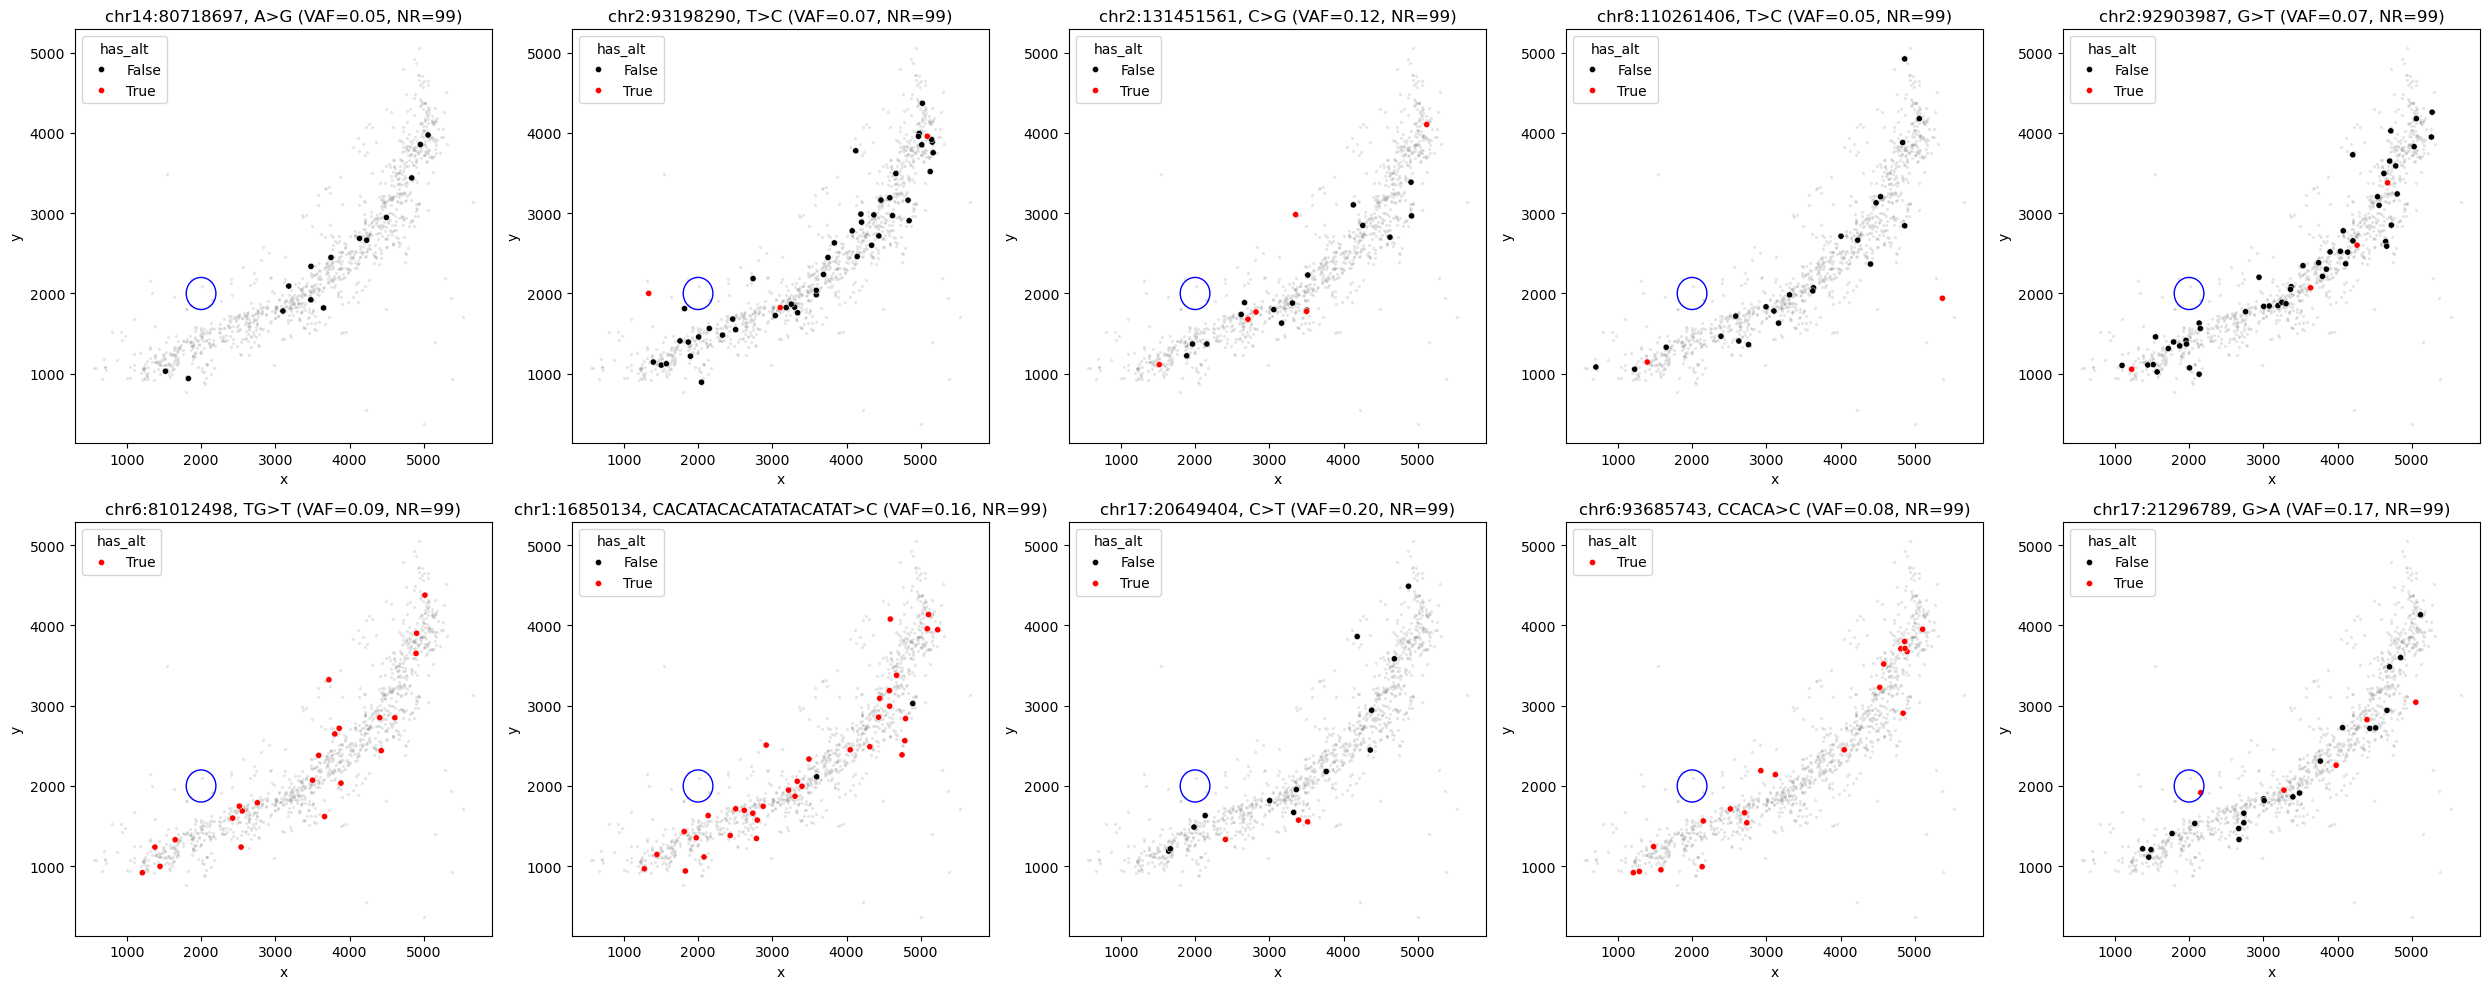

In [144]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
flat_axes = axes.flatten()

j = 0
for i, r in maf_df.sort_values(by='NR').tail(10).iterrows():
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner')
    
    sns.scatterplot(colon_spatial_df, x='x', y='y', color='gray', alpha=0.2, linewidth=0, s=5, ax=flat_axes[j])
    sns.scatterplot(i_cb_df, x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
    circle = plt.Circle((2000, 2000), 200, color='b', fill=False)
    flat_axes[j].add_artist(circle)
    flat_axes[j].set_title(f'{r["Chr"]}:{r["Pos"]}, {r["Ref"]}>{r["Alt"]} (VAF={r["VAF"]:.2f}, NR={r["NR"]})')
    j += 1
    
plt.tight_layout()
plt.show()

TODO: filter the spatially unmapped cells, then rerun mutect

Of all the places where reads aligned to the region, local vaf

In [78]:
from sklearn.cluster import DBSCAN

In [119]:
i_cb_df[['x', 'y']].dropna().sort_values(by=['x', 'y'])

,x,y
CB,,
GTCTTTAACTCACAAA,1520.794400,1031.577600
GGCTTCGCTCAAAGGT,1828.994410,940.675754
AACAGCTACTATTAGG,3102.692720,1781.430680
GCTCGACCTAACCGGA,3181.646600,2092.384400
TAGGATGCTTTCTTCG,3479.216655,1921.099064
GACTAGGCTTCCAGCA,3480.911143,2337.866714
CATTCCTCTAGGTCCC,3650.052560,1820.018480
TGCCAGAACTAAGGTT,3749.982190,2448.656381
CAGGTTCCTCCAACCA,4134.350868,2687.080415


In [88]:
clustering = DBSCAN(eps=1000, min_samples=2).fit(i_cb_df[['x', 'y']].dropna())

In [89]:
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [91]:
maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF
0,chr1,16856,A,G,5,44,0.113636
1,chr1,108540,A,C,7,44,0.159091
2,chr1,127491,T,G,16,70,0.228571
3,chr1,268043,C,T,11,78,0.141026
4,chr1,275337,T,C,6,55,0.109091
...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474
68877,chrY,56881603,G,A,8,93,0.086022
68878,chrY,56881615,T,C,8,90,0.088889
68879,chrY,56881889,G,C,10,95,0.105263


In [148]:
for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner').query('has_alt').dropna(subset=['x', 'y'])
    if i_cb_df.shape[0] == 0:
        continue
    
    clustering = DBSCAN(eps=200, min_samples=2).fit(i_cb_df[['x', 'y']])
    
    labels = clustering.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    maf_df.loc[i, 'DBSCAN_n_clusters'] = n_clusters_
    maf_df.loc[i, 'DBSCAN_n_noise'] = n_noise_

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68881/68881 [06:17<00:00, 182.57it/s]


<Axes: xlabel='DBSCAN_n_clusters', ylabel='count'>

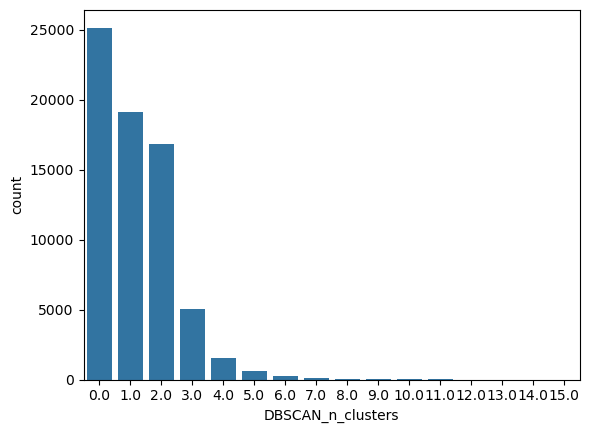

In [158]:
sns.barplot(maf_df['DBSCAN_n_clusters'].value_counts())

In [295]:
maf_df.query('DBSCAN_n_clusters == 1').tail(20)

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor,type
68819,chrX,154497131,TA,CT,3,53,0.056604,1.0,0.0,NaN,NaN,NaN,True
68820,chrX,154605020,GGCTA,G,3,46,0.065217,1.0,9.0,375.555611,206.936517,11.0,True
68833,chrX,155249439,TT,AC,3,53,0.056604,1.0,0.0,NaN,NaN,NaN,True
68835,chrX,155299999,C,T,7,62,0.112903,1.0,6.0,575.086047,326.201240,8.0,False
68838,chrX,155426015,T,C,3,44,0.068182,1.0,0.0,NaN,NaN,NaN,False
68839,chrX,155426020,G,T,3,44,0.068182,1.0,0.0,NaN,NaN,NaN,False
68845,chrX,155730768,GACTCC,G,3,51,0.058824,1.0,2.0,950.539303,613.927195,4.0,True
68846,chrX,155768592,G,A,4,78,0.051282,1.0,1.0,NaN,NaN,NaN,False
68847,chrX,155768596,A,G,4,77,0.051948,1.0,1.0,NaN,NaN,NaN,False
68849,chrX,155796830,TTTTAA,T,3,43,0.069767,1.0,4.0,412.573382,219.333581,6.0,True


/local/scratch/50089287.1.interactive/ipykernel_63995/3464183177.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(i_cb_df.query('has_alt'), x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
/local/scratch/50089287.1.interactive/ipykernel_63995/3464183177.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(i_cb_df.query('has_alt'), x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
/local/scratch/50089287.1.interactive/ipykernel_63995/3464183177.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(i_cb_df.query('has_alt'), x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
/local/scratch/50089287.1.interactive/ipykernel_63995/3464183177.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot

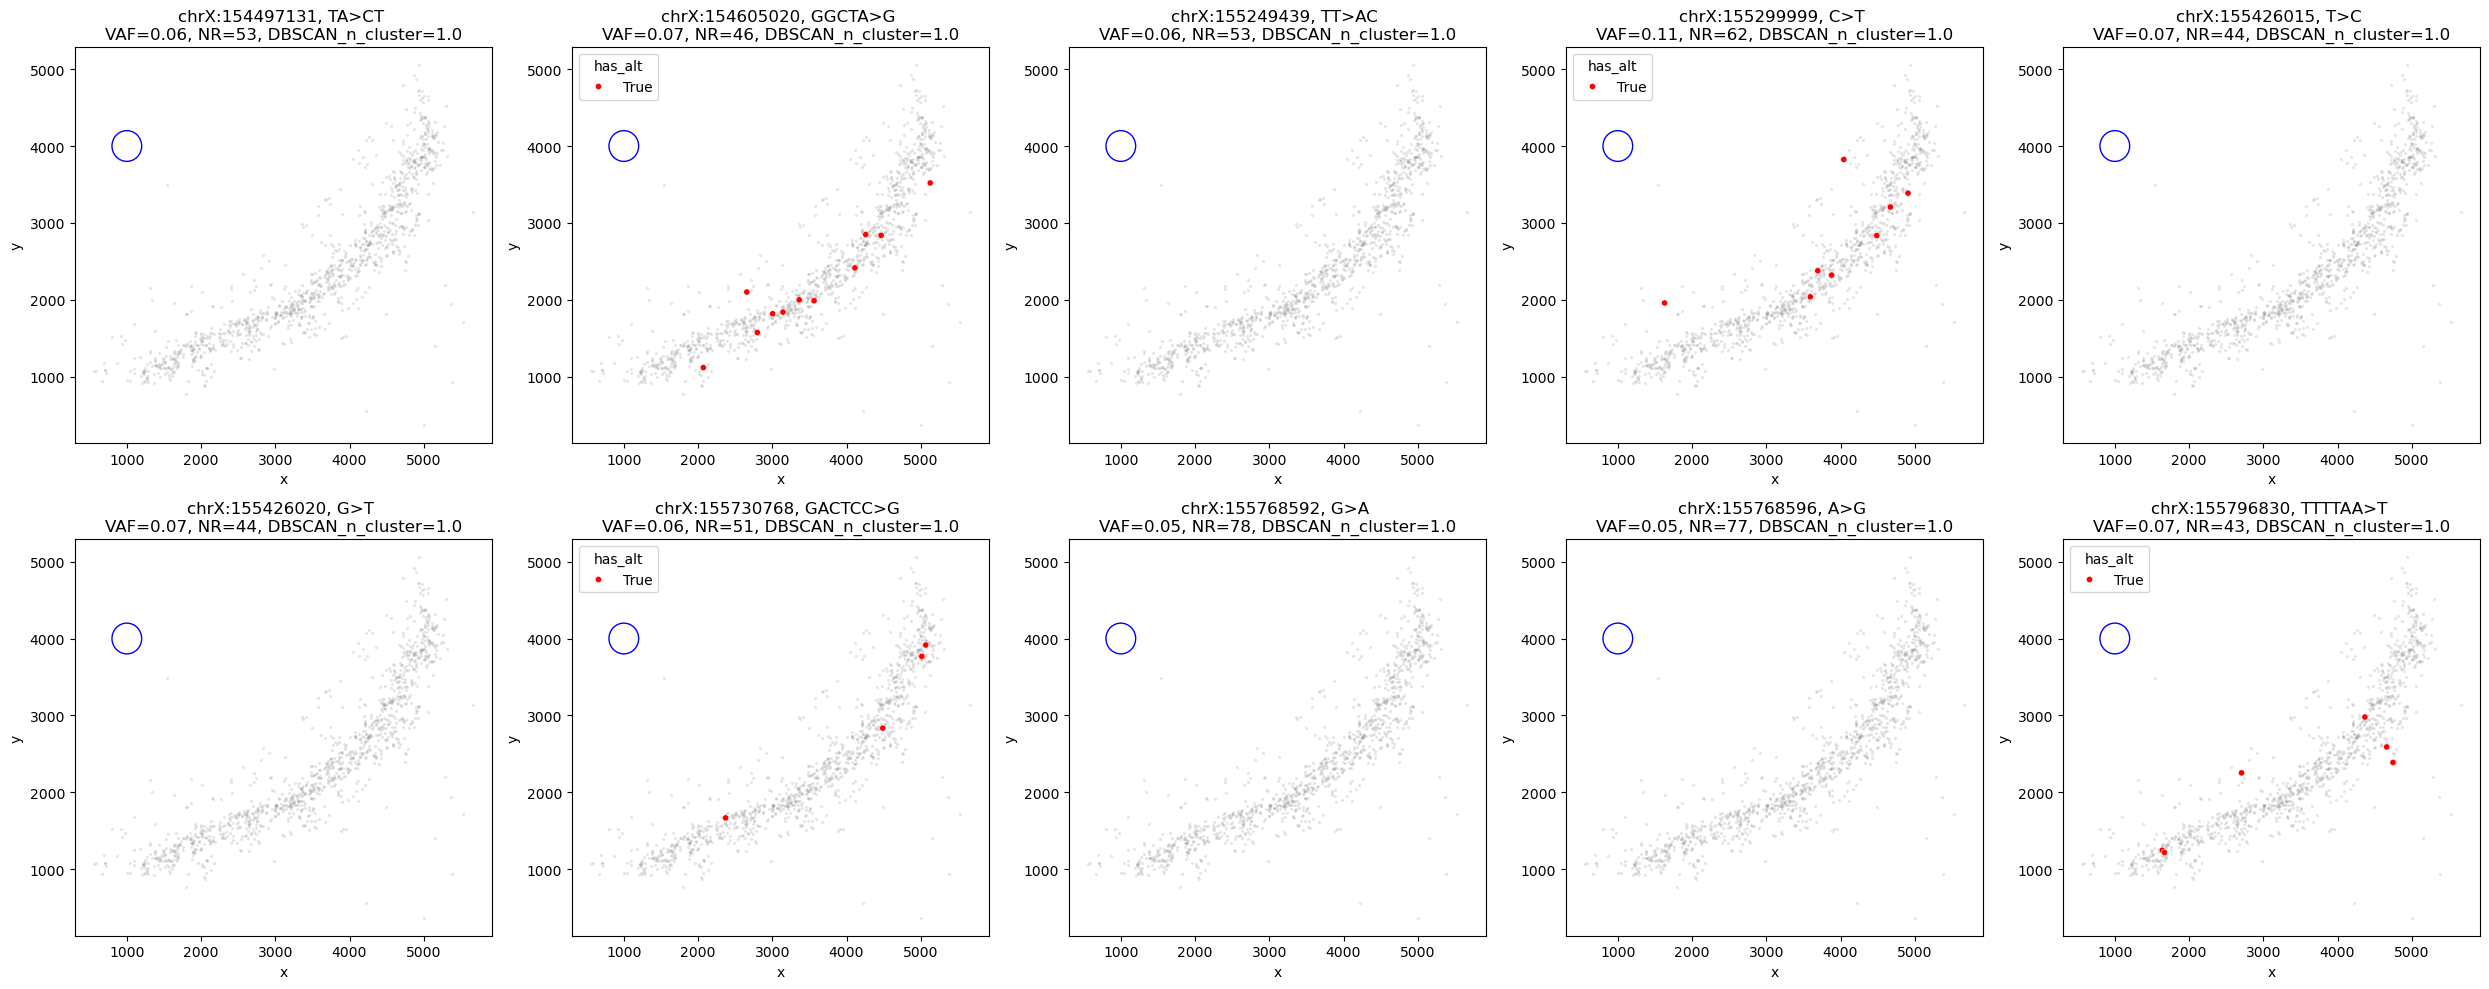

In [165]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
flat_axes = axes.flatten()

j = 0
for i, r in maf_df.query('DBSCAN_n_clusters == 1').tail(20).iterrows():
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner')
    
    sns.scatterplot(colon_spatial_df, x='x', y='y', color='gray', alpha=0.2, linewidth=0, s=5, ax=flat_axes[j])
    sns.scatterplot(i_cb_df.query('has_alt'), x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
    circle = plt.Circle((1000, 4000), 200, color='b', fill=False)
    flat_axes[j].add_artist(circle)
    flat_axes[j].set_title(f'{r["Chr"]}:{r["Pos"]}, {r["Ref"]}>{r["Alt"]} \nVAF={r["VAF"]:.2f}, NR={r["NR"]}, DBSCAN_n_cluster={r["DBSCAN_n_clusters"]}')
    j += 1
    
plt.tight_layout()
plt.show()

In [178]:
from sklearn.metrics import pairwise_distances
X = i_cb_df.query('has_alt')[['x', 'y']].dropna().copy()
D = pairwise_distances(X)
np.fill_diagonal(D, D.max())

In [186]:
D

array([[2368.5521188, 2368.5521188],
       [2368.5521188, 2368.5521188]])

In [187]:
D.min(axis=1) #.mean()

array([2368.5521188, 2368.5521188])

In [202]:
for i, r in tqdm.tqdm(maf_df.iterrows(), total=maf_df.shape[0]):
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner').query('has_alt').dropna(subset=['x', 'y'])
    if i_cb_df.shape[0] == 0:
        continue
        
    X = i_cb_df[['x', 'y']].copy()
    D = pairwise_distances(X)
    np.fill_diagonal(D, D.max()) # remove self
    nearest_neighbor_dists = D.min(axis=1)
    # average nearest neighbor distance
    ANN_mean = np.mean(nearest_neighbor_dists) 
    ANN_median = np.median(nearest_neighbor_dists)
    
    maf_df.loc[i, 'ANN_num_CBs_w_coor'] = i_cb_df.shape[0]
    maf_df.loc[i, 'ANN_mean'] = ANN_mean
    maf_df.loc[i, 'ANN_median'] = ANN_median
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68881/68881 [06:21<00:00, 180.37it/s]


In [203]:
maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
0,chr1,16856,A,G,5,44,0.113636,0.0,1.0,0.000000,0.000000,1.0
1,chr1,108540,A,C,7,44,0.159091,0.0,2.0,4257.471057,4257.471057,2.0
2,chr1,127491,T,G,16,70,0.228571,0.0,3.0,1995.358693,1477.602969,3.0
3,chr1,268043,C,T,11,78,0.141026,0.0,2.0,2379.343187,2379.343187,2.0
4,chr1,275337,T,C,6,55,0.109091,0.0,3.0,682.600559,531.186754,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474,1.0,6.0,592.596702,473.749510,8.0
68877,chrY,56881603,G,A,8,93,0.086022,2.0,8.0,426.856579,365.575918,12.0
68878,chrY,56881615,T,C,8,90,0.088889,4.0,7.0,359.732644,192.454720,15.0
68879,chrY,56881889,G,C,10,95,0.105263,1.0,1.0,186.051942,68.134522,3.0


In [204]:
cols = "DBSCAN_n_clusters	DBSCAN_n_noise ANN_num_CBs_w_coor ANN_mean	ANN_median".split()
cb_maf_df.loc[maf_df.index, cols] = maf_df[cols]

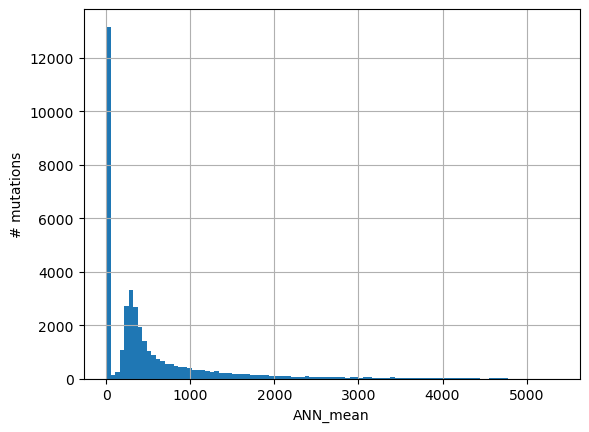

In [205]:
cb_maf_df['ANN_mean'].hist(bins=100)
plt.xlabel('ANN_mean')
plt.ylabel('# mutations')
plt.show()

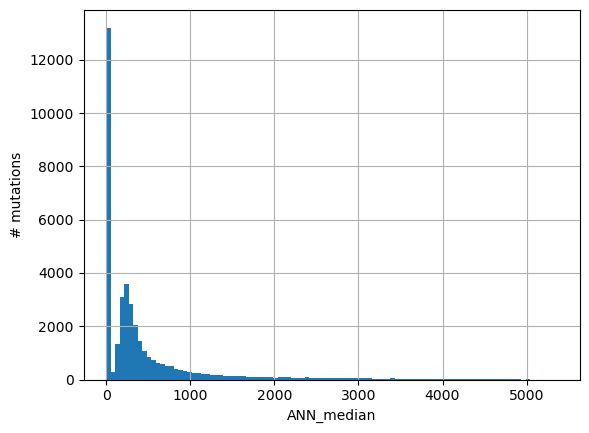

In [206]:
cb_maf_df['ANN_median'].hist(bins=100)
plt.xlabel('ANN_median')
plt.ylabel('# mutations')
plt.show()

In [207]:
cb_maf_df.head()

,alt,ref,num_CBs,num_CBs_with_alt,total,CB_VAF,bulk_VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
maf_idx,,,,,,,,,,,,
0,15,100,65,8.0,115,0.130435,0.113636,0.0,1.0,0.000000,0.000000,1.0
1,7,48,34,5.0,55,0.127273,0.159091,0.0,2.0,4257.471057,4257.471057,2.0
2,29,103,75,16.0,132,0.219697,0.228571,0.0,3.0,1995.358693,1477.602969,3.0
3,12,102,65,7.0,114,0.105263,0.141026,0.0,2.0,2379.343187,2379.343187,2.0
4,9,74,51,6.0,83,0.108434,0.109091,0.0,3.0,682.600559,531.186754,3.0


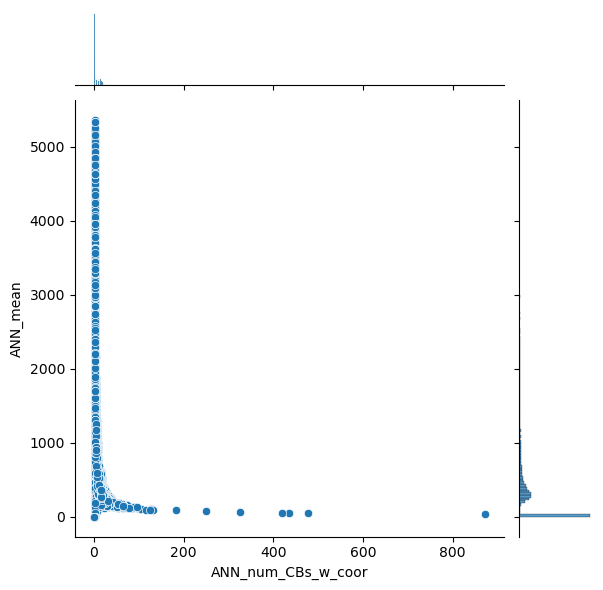

In [208]:
sns.jointplot(cb_maf_df, x='ANN_num_CBs_w_coor', y='ANN_mean')

In [214]:
cb_maf_df.query('ANN_mean < 100 and ANN_num_CBs_w_coor > 3')

,alt,ref,num_CBs,num_CBs_with_alt,total,CB_VAF,bulk_VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
maf_idx,,,,,,,,,,,,
10076,10,34,30,10.0,44,0.227273,0.114286,3.0,0.0,79.707158,84.284458,6.0
19111,19,113,79,11.0,132,0.143939,0.122807,2.0,1.0,76.598116,50.931930,5.0
23774,2106,64,1572,1250.0,2170,0.970507,0.105263,6.0,16.0,55.475453,37.821655,436.0
23789,2431,1104,1868,1284.0,3535,0.687694,0.192308,8.0,9.0,56.127455,41.080560,420.0
23937,1334,1334,1494,779.0,2668,0.500000,0.106667,3.0,17.0,82.361169,58.367308,250.0
23946,2641,431,1614,1408.0,3072,0.859701,0.084746,6.0,15.0,58.023868,37.706654,477.0
25153,40,0,24,24.0,40,1.000000,0.081081,3.0,0.0,72.008301,52.722216,7.0
25207,1811,165,1026,939.0,1976,0.916498,0.236842,2.0,15.0,72.174023,55.743949,326.0
33544,779,0,591,529.0,779,1.000000,0.128205,10.0,9.0,89.828821,65.295608,183.0


In [234]:
i_cb_df

,alt,ref,other,genotype,has_alt,DBSCAN_n_clusters,DBSCAN_n_noise,RNA_CB,cell_type,x,y,cell_type_broad
CB,,,,,,,,,,,,
TGGGTTAGATTCAATC,7,0,0,7/0,True,NaN,NaN,CAAAGTGAGCTATGAC-1,Early Epithelial,3651.728947,2085.748316,Epithelial
ACACTTGCTTCATTGA,4,0,0,4/0,True,NaN,NaN,AGCTATATCAACAAGG-1,Progenitor Epithelial,4432.072914,2831.872638,Epithelial
GGGAACAACCGTTACT,7,0,1,7/0,True,NaN,NaN,GGTGTGACACTCGCTC-1,Progenitor Epithelial,NaN,NaN,Epithelial
CAACATAACCCAAAGC,6,0,0,6/0,True,NaN,NaN,GTCGGTTCAGGAACCA-1,Macorphage,3380.633946,1566.893308,Immune
AACCATGACTTCATCG,2,0,1,2/0,True,NaN,NaN,GTTCGCGCAAACGCGA-1,Fibroblast_2,NaN,NaN,Stromal
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCAACTGGTCTTA,1,0,0,1/0,True,NaN,NaN,GCTTTCATCAATGAGG-1,Early Epithelial,NaN,NaN,Epithelial
GCTGAGGTGTAACGAA,1,0,0,1/0,True,NaN,NaN,ACACCTTGTGAAGCCT-1,Fibroblast_2,NaN,NaN,Stromal
CTATATGCTATATCGC,1,0,0,1/0,True,NaN,NaN,GTAGCTGTCCCTGATC-1,Fibroblast_1,4583.697037,2618.374815,Stromal


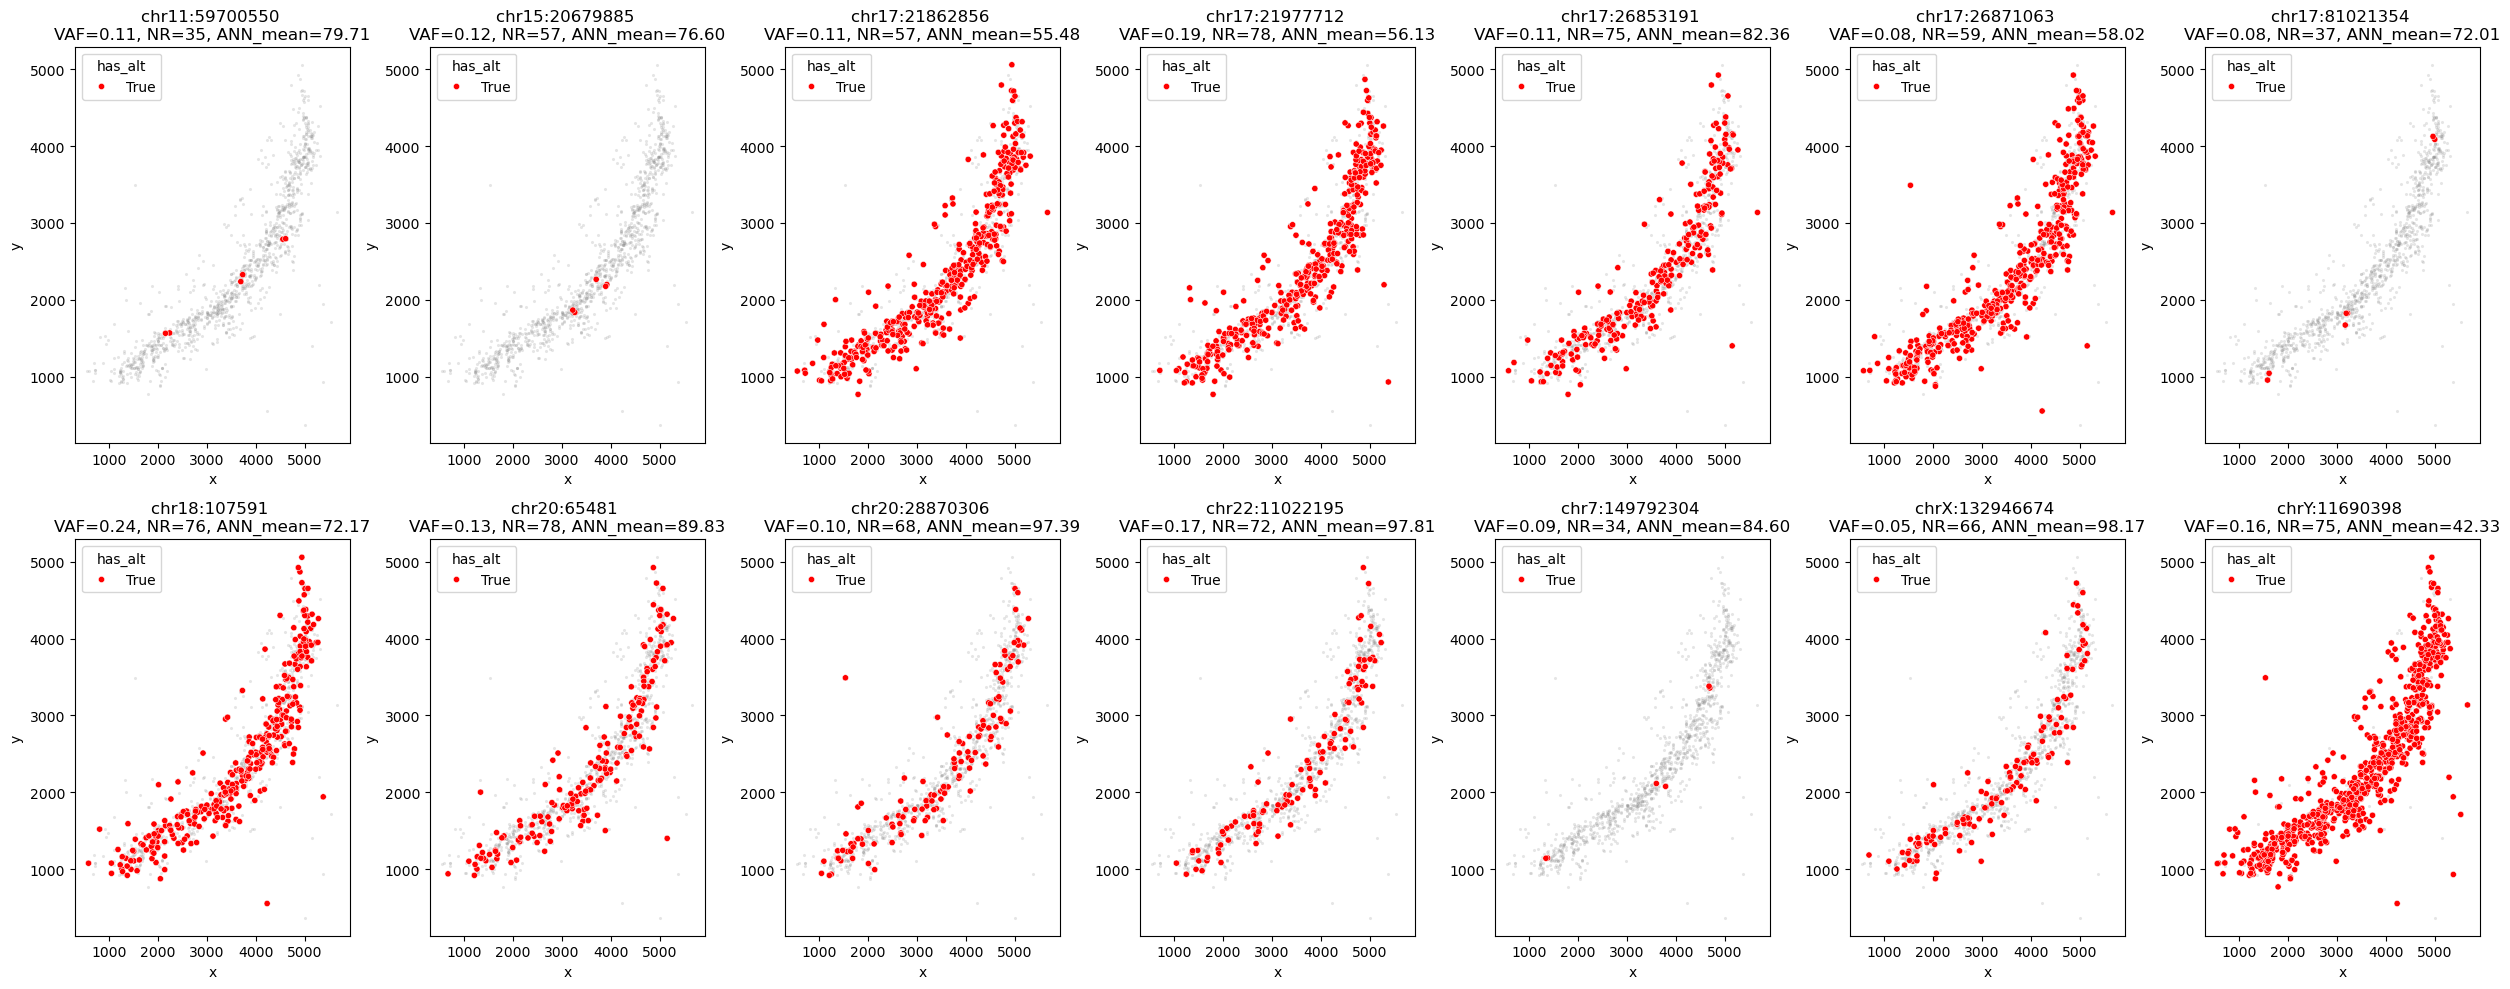

In [221]:

likely_clustered_df = cb_maf_df.query('ANN_mean < 100 and ANN_num_CBs_w_coor > 3')

fig, axes = plt.subplots(2, int(np.ceil(likely_clustered_df.shape[0]/2)), figsize=(25, 10))
flat_axes = axes.flatten()

j = 0
for i, r in maf_df.loc[likely_clustered_df.index].iterrows():
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner')
    
    sns.scatterplot(colon_spatial_df, x='x', y='y', color='gray', alpha=0.2, linewidth=0, s=5, ax=flat_axes[j])
    sns.scatterplot(i_cb_df.query('has_alt'), x='x', y='y', hue='has_alt', s=20, ax=flat_axes[j], palette={True: 'r', False: 'k'})
    flat_axes[j].set_title(f'{r["Chr"]}:{r["Pos"]} \nVAF={r["VAF"]:.2f}, NR={r["NR"]}, ANN_mean={r["ANN_mean"]:.2f}')
    j += 1
    
plt.tight_layout()
plt.show()

TODO: Stratify by cell types

In [297]:
colon_spatial_df

,cell_type,x,y,cell_type_broad
AAACCGAAGGCAATAG-1,Intermediate Epithelial,NaN,NaN,Epithelial
AAACCGAAGTATCGCG-1,Progenitor Epithelial,4639.436632,3248.049118,Epithelial
AAACCGGCATCTTGAG-1,T cell,NaN,NaN,Immune
AAACGCGCATGGAGGC-1,Fibroblast_1,2043.568952,1025.101805,Stromal
AAACGGATCATGCTTT-1,Goblet,4539.478596,3205.408255,Epithelial
...,...,...,...,...
TTTGGTAAGGAGCACG-1,Fibroblast_1,NaN,NaN,Stromal
TTTGTGAAGCATGAAG-1,Goblet,1923.926680,1428.126448,Epithelial
TTTGTGAAGGACCAGG-1,Progenitor Epithelial,NaN,NaN,Epithelial
TTTGTGTTCCGTGACA-1,Progenitor Epithelial,3482.962226,2015.009358,Epithelial


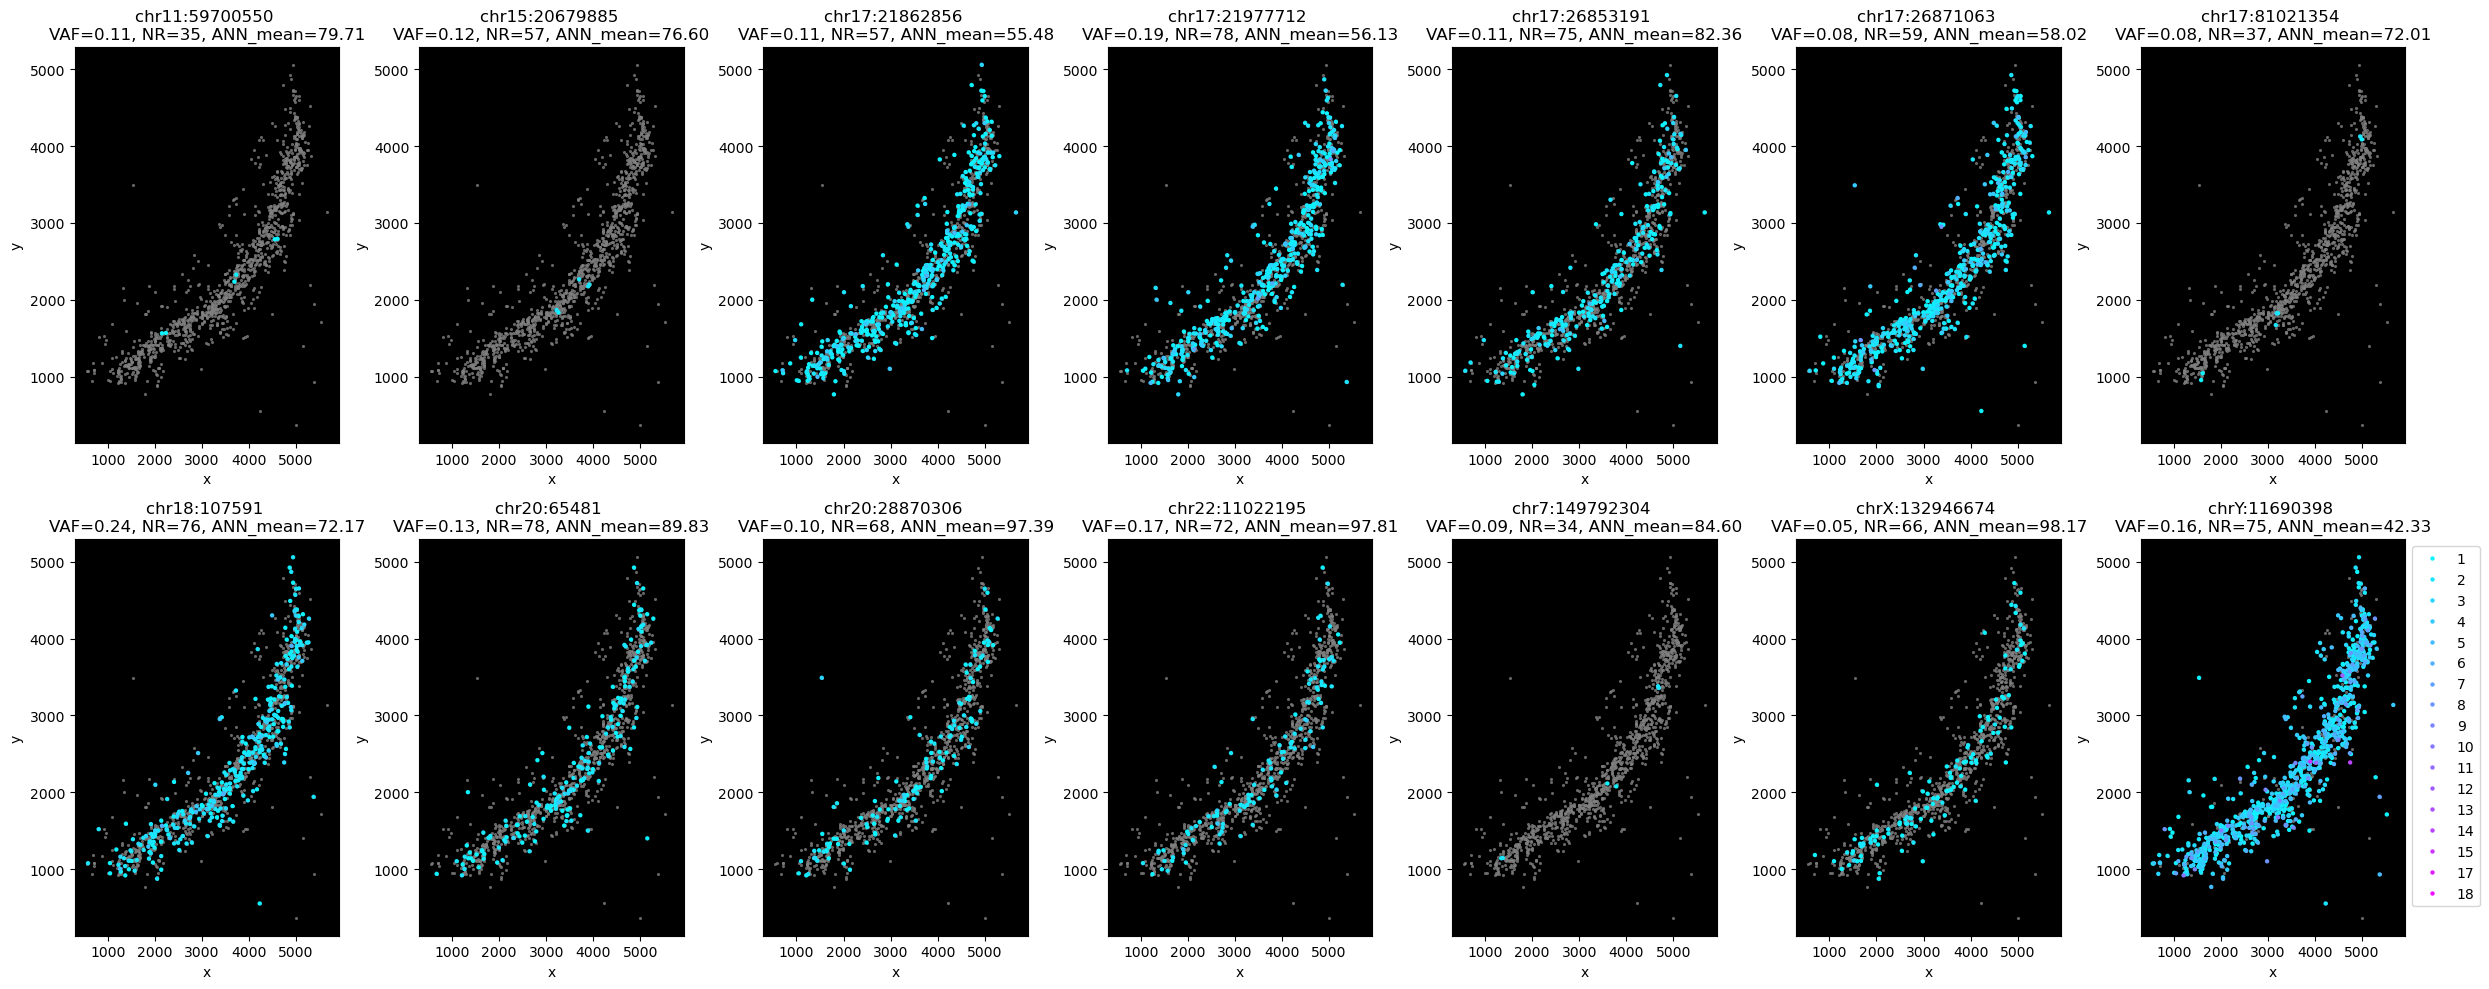

In [258]:
import matplotlib 
likely_clustered_df = cb_maf_df.query('ANN_mean < 100 and ANN_num_CBs_w_coor > 3')

cmap = matplotlib.cm.cool  # Use the 'viridis' colormap

# Generate 20 evenly spaced values across the range [0, 1]
num_values = 20
values = np.linspace(0, 1, num_values)

# Apply the colormap to these values
color_map = {i: cmap(values[i]) for i in range(20)}

fig, axes = plt.subplots(2, int(np.ceil(likely_clustered_df.shape[0]/2)), figsize=(25, 10))
flat_axes = axes.flatten()

j = 0
for i, r in maf_df.loc[likely_clustered_df.index].iterrows():
    i_cb_df = cb_counts_df.loc[i].copy()
    i_cb_df['RNA_CB'] = convert_cb_df.loc[i_cb_df.index, 'RNA'] + '-1'
    
    i_cb_df = i_cb_df.merge(colon_spatial_df, left_on='RNA_CB', right_index=True, how='inner')
    
    sns.scatterplot(colon_spatial_df, x='x', y='y', color='gray', alpha=0.8, linewidth=0, s=5, ax=flat_axes[j])
    sns.scatterplot(i_cb_df.query('has_alt').sort_values(by='alt'), x='x', y='y', hue='alt', s=10, ax=flat_axes[j], palette=color_map, linewidth=0)
    flat_axes[j].set_title(f'{r["Chr"]}:{r["Pos"]} \nVAF={r["VAF"]:.2f}, NR={r["NR"]}, ANN_mean={r["ANN_mean"]:.2f}')
    
    flat_axes[j].get_legend().set_visible(False)
    flat_axes[j].set_facecolor('black')
    j += 1
    
flat_axes[j - 1].legend(bbox_to_anchor = (1, 1))
    
plt.tight_layout()
plt.show()

Possible doublets?

<Axes: xlabel='CB_VAF', ylabel='ANN_mean'>

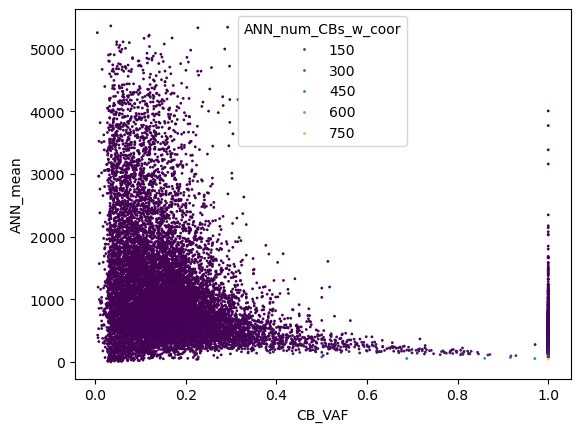

In [299]:
sns.scatterplot(cb_maf_df.query('ANN_num_CBs_w_coor > 1').sort_values(by='ANN_num_CBs_w_coor'), x='CB_VAF', y='ANN_mean', hue='ANN_num_CBs_w_coor', s=4, linewidth=0, palette='viridis')

TODO: crypts ~100-200. Slide tags pick up about 20%?

In [227]:
cb_maf_df

,Chr,Pos,Ref,Alt,NV,NR,VAF,DBSCAN_n_clusters,DBSCAN_n_noise,ANN_mean,ANN_median,ANN_num_CBs_w_coor
0,chr1,16856,A,G,5,44,0.113636,0.0,1.0,0.000000,0.000000,1.0
1,chr1,108540,A,C,7,44,0.159091,0.0,2.0,4257.471057,4257.471057,2.0
2,chr1,127491,T,G,16,70,0.228571,0.0,3.0,1995.358693,1477.602969,3.0
3,chr1,268043,C,T,11,78,0.141026,0.0,2.0,2379.343187,2379.343187,2.0
4,chr1,275337,T,C,6,55,0.109091,0.0,3.0,682.600559,531.186754,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
68876,chrY,56878123,T,C,18,95,0.189474,1.0,6.0,592.596702,473.749510,8.0
68877,chrY,56881603,G,A,8,93,0.086022,2.0,8.0,426.856579,365.575918,12.0
68878,chrY,56881615,T,C,8,90,0.088889,4.0,7.0,359.732644,192.454720,15.0
68879,chrY,56881889,G,C,10,95,0.105263,1.0,1.0,186.051942,68.134522,3.0


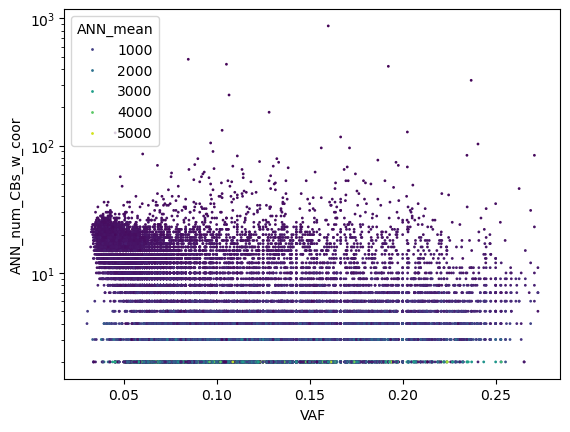

In [267]:
sns.scatterplot(maf_df.query('ANN_num_CBs_w_coor > 1'), x='VAF', y='ANN_num_CBs_w_coor', hue='ANN_mean', s=4, linewidth=0, palette='viridis')
plt.yscale('log')

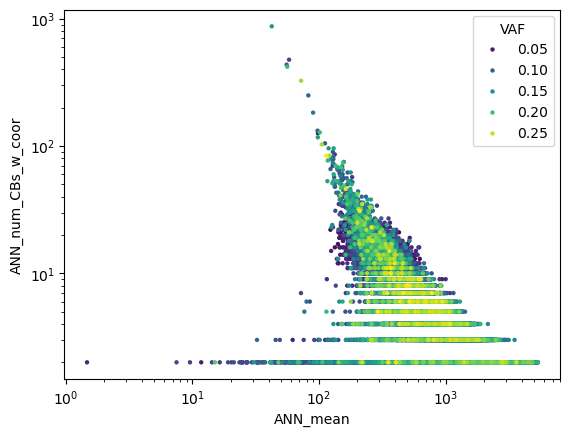

In [272]:
sns.scatterplot(maf_df.query('ANN_num_CBs_w_coor > 1').sort_values(by='VAF'), x='ANN_mean', y='ANN_num_CBs_w_coor', hue='VAF', s=10, linewidth=0, palette='viridis')
plt.yscale('log')
plt.xscale('log')
plt.show()

Background density vs observed density? maybe their spatial permutation addresses this

In [273]:
from scipy.stats import permutation_test

In [274]:
cb_counts_df.loc[i]

KeyError: 68871